In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output

In [2]:
df=pd.read_csv('lake/LIRO.csv',index_col=0)
df.index=pd.to_datetime(df.index)

In [3]:
albedo=df.SWOUT/df.SWIN

In [4]:
albedo=albedo[albedo.between(0,1)]

In [5]:
albedo_median=np.round(albedo.median(),2)

In [6]:
copyfile("./runs/data/" + 'LIRO' + "_" + "data_60.txt",
             "runs/run/input/Kc_2012_data_60.txt")

'runs/run/input/Kc_2012_data_60.txt'

In [7]:
path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
#df_state_init = sp.init_supy(path_runcontrol)
df_state_init, df_forcing = sp.load_SampleData()
grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

2019-11-25 15:51:06,133 — SuPy — INFO — All cache cleared.
2019-11-25 15:51:07,621 — SuPy — INFO — All cache cleared.


In [8]:
df_forcing_run_2=df_forcing_run.loc['2019 08 01':'2019 8 30']

In [9]:
df_state_init.loc[:,'state_id']=[0,0,0,0,0,0,20000]
df_state_init.loc[:,'sfr']=[0,0,0,0,0,0,1]
df_state_init.loc[:,'lat']=45.998269
df_state_init.loc[:,'lng']=-89.704767
temp=df_state_init.loc[:,'alb'].values[0]
temp[-1]=albedo_median
df_state_init.loc[:,'alb']=temp
df_state_init.loc[:, 'emissionsmethod'] = 0
df_state_init.loc[:,'roughlenheatmethod']=1
df_state_init.loc[:,'roughlenmommethod']=1
df_state_init.loc[:,'z0m_in']=.01
df_state_init.loc[:,'zdm_in']=0
df_state_init.loc[:, 'z']=3
df_state_init.snowuse=0

In [10]:
a=df_state_init.loc[:,'ohm_coef'].values[0]
for i in [0,1,2,3]:
    s=6
    a[(s)*4*3+((i)*3)+(0)]=0.446346
    a[(s)*4*3+((i)*3)+(1)]=0.0846668
    a[(s)*4*3+((i)*3)+(2)]=-113.396

#     a[(s)*4*3+((i)*3)+(0)]=0.478701
#     a[(s)*4*3+((i)*3)+(1)]=0.0769846
#     a[(s)*4*3+((i)*3)+(2)]=-123.77
df_state_init.loc[:,'ohm_coef']=a

In [11]:
df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                        df_state_init,
                                        save_state=False)

2019-11-25 15:51:11,630 — SuPy — INFO — ====================
2019-11-25 15:51:11,633 — SuPy — INFO — Simulation period:
2019-11-25 15:51:11,634 — SuPy — INFO —   Start: 2019-08-01 00:00:00
2019-11-25 15:51:11,635 — SuPy — INFO —   End: 2019-08-30 23:55:00
2019-11-25 15:51:11,636 — SuPy — INFO — 
2019-11-25 15:51:11,638 — SuPy — INFO — No. of grids: 1
2019-11-25 15:51:11,639 — SuPy — INFO — SuPy is running in serial mode
2019-11-25 15:51:14,248 — SuPy — INFO — Execution time: 2.6 s
2019-11-25 15:51:14,249 — SuPy — INFO — ====================



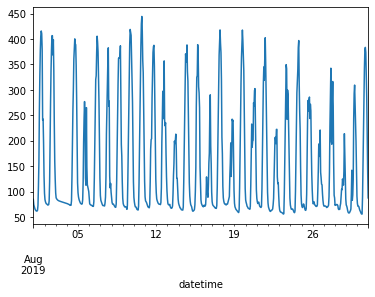

In [12]:
out=df_output.SUEWS.loc[grid]
out.resample('1h').mean().QE.plot()

In [13]:
bb=out.Evap.resample('1d').sum()

In [14]:
aa=df.surfacewaterElev.loc['2019 08 01':'2019 8 30'].dropna().resample('1D').mean()

In [15]:
aa_diff=aa.diff()*1000
all_diff=aa_diff[(aa_diff<-.1)&(aa_diff>-20)]
all_diff.index=all_diff.index-datetime.timedelta(days=1)

In [16]:
meas=-1*all_diff
model=bb.loc[all_diff.index.date]

Text(0, 0.5, 'evaporation (mm)')

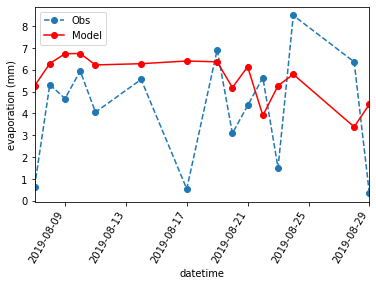

In [20]:
meas.plot(marker='o',linestyle='--')
model.plot(marker='o',color='r',linestyle='-')
plt.xticks(rotation=60)
plt.legend(['Obs','Model'])
plt.ylabel('evaporation (mm)')